<h1>Siamese Model Training</h1>


Siamese networks have become a powerful approach in the domain of facial recognition due to their ability to effectively measure the similarity between pairs of images. Unlike traditional classification models, which classify each image independently, Siamese networks focus on learning a distance function that quantifies how similar or dissimilar two input images are. This is achieved by embedding images into a shared feature space, where similar images (e.g., two photos of the same person) are close together, while dissimilar images (e.g., photos of different people) are far apart. In this project, we aim to build a Siamese network for facial recognition, which will be trained to identify whether two images belong to the same person or not. By leveraging a pretrained ResNet50 model for feature extraction and custom layers for comparison, the network will learn to distinguish facial features in a manner that generalizes across various lighting conditions, angles, and expressions. Our ultimate goal is to develop and deploy a facial recognition model for an attendance system


-   This notebook builds upon the work done by Nicholas Renotte at
-   https://github.com/nicknochnack/FaceRecognition/blob/main/Facial%20Verification%20with%20a%20Siamese%20Network%20-%20Final.ipynb
-   and https://youtu.be/bK_k7eebGgc

**Summary of Key Changes / Improvements:**

1. Image Preprocessing Enhancements

-   Centralized Preprocessing: The image preprocessing has been centralized into the ImageLoader class, making it reusable and more organized. The preprocess_image function:
    -   Loading: Uses cv2.imread to load the image and handles cases where the image cannot be loaded by raising a ValueError.
    -   Resizing: Resizes the image to the target dimensions specified by the config.img_size, ensuring that all input images to the network are consistent.
    -   Color Conversion: Converts the image from BGR (OpenCV’s default) to RGB format, which is more commonly used for deep learning tasks.
    -   Normalization: Normalizes the pixel values to the range of [-1, 1] by subtracting 127.5 and dividing by 127.5. This helps the model converge faster during training by making the input data distribution more centered.

2. Data Pair Generation and Handling

-   **Changed dataset structure to have folders of many people's images and create positive and negative images based on this**

-   Balanced Pair Generation: The DataGenerator class generates both positive and negative pairs for the Siamese network:
    -   Positive Pairs: Pairs of images from the same person are generated randomly. A limit of 20 pairs is used to avoid excessive number generation.
    -   Negative Pairs: Pairs of images from different people are generated to introduce contrastive learning. The number of negative pairs matches the positive pairs, ensuring balanced training.
    -   Shuffling and Labeling: After generating the pairs, the labels (1 for positive, 0 for negative) are shuffled to prevent the model from learning the order of examples.
    -   Efficiency in Dataset Creation: The generator produces the data on-the-fly using a custom generator() function within the create_dataset() method. This minimizes memory usage by not preloading the entire dataset into memory.

3. Handling Dataset Creation for TensorFlow

-   TensorFlow Dataset Integration: In the create_datasets method:
    -   The generated pairs and labels are used to create a TensorFlow dataset (tf.data.Dataset), which allows for better efficiency during training.
    -   Shuffling and Batching: The dataset is shuffled for training and batched for efficient processing. The prefetch() function improves performance by allowing data loading to occur in the background while the model is training.

4. Custom Layer Enhancements

-   L2 Normalization Layer: A custom L2NormalizationLayer normalizes the output feature vectors from the base network using L2 normalization. This ensures that the embeddings are of unit length, which helps the network learn meaningful distances between image pairs.
-   L2 Distance Layer: The L2DistanceLayer computes the Euclidean (L2) distance between two feature vectors, which is a fundamental step in Siamese networks to measure similarity between pairs. It includes a safeguard for numerical stability by ensuring the computed distance is not too small (using tf.keras.backend.epsilon()).

5. **Model Architecture and Configuration**

-   Base Network using ResNet50:
    -   Pretrained Model: The base network is built using the pre-trained ResNet50 model, with its top layers removed (include_top=False) to use it as a feature extractor.
    -   Freezing Early Layers: By freezing most of the ResNet50 layers (keeping only the last 50 layers trainable), the network leverages the learned features from ImageNet while fine-tuning for the Siamese network task.
    -   Dense Layers with Regularization: After pooling, the model includes several dense layers with BatchNormalization, LeakyReLU activations, and Dropout layers. These provide better feature representation learning and regularize the network to avoid overfitting.

6. **Model Compilation and Training Enhancements**

-   Custom Optimizer: The Adam optimizer is used with a learning rate from the configuration and gradient clipping (using clipnorm=1.0), which helps stabilize training by controlling gradient explosions.
-   Learning Rate Reduction on Plateau: A ReduceLROnPlateau callback is used to reduce the learning rate when the validation loss stops improving, which is crucial for fine-tuning the model and achieving better convergence.
-   Training with Callbacks: The model is trained with the specified datasets and includes callbacks to monitor validation performance and adjust the learning rate accordingly.

7. Code Efficiency and Structure

-   Parallelized Dataset Loading: By using tf.data.AUTOTUNE with the prefetch() method, TensorFlow can automatically determine the optimal number of data elements to prefetch, improving data loading efficiency.
-   Code is structured using classes


Run code on kaggle notebooks with GPU harware accelerator enabled.


<h3>Imports</h3>


In [ ]:
# Standard library imports
import os  # Provides functions for interacting with the operating system (e.g., file paths, environment variables).
import logging  # Used for logging messages to debug or monitor the application's flow.
from pathlib import Path  # Offers an object-oriented interface for filesystem paths.

# Third-party library imports
import cv2  # OpenCV: a library for image processing tasks such as reading, modifying, and analyzing images.
import numpy as np  # Provides support for numerical computations and handling multi-dimensional arrays.
import tensorflow as tf  # TensorFlow: a deep learning framework for building and training machine learning models.
from tensorflow.keras import (
    layers,
    Model,
)  # Used for defining neural network layers and custom models.
from sklearn.model_selection import (
    train_test_split,
)  # Utility for splitting data into training and validation sets.
from tqdm import (
    tqdm,
)  # Provides a progress bar for loops, useful when processing large datasets.

# Specific TensorFlow components
from tensorflow.keras.applications import (
    ResNet50,
)  # Pretrained ResNet50 model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# EarlyStopping: Stops training when validation performance plateaus to prevent overfitting.
# ReduceLROnPlateau: Reduces learning rate if validation performance stagnates.

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augments image data (e.g., rotation, flipping, scaling) to increase dataset variability and prevent overfitting.

# Type hinting imports
from typing import (
    Tuple,
    List,
)  # Provides support for type hints in Python, improving code readability and maintainability.

In [ ]:
# Configure logging for the application
logging.basicConfig(
    level=logging.INFO,  # Set logging level to INFO; it will log informational messages and above (e.g., warnings, errors).
    format="%(asctime)s - %(levelname)s - %(message)s",  # Define the format for log messages: timestamp, log level, and message.
)
logger = logging.getLogger(
    __name__
)  # Create a logger instance with the name of the current module.
# This logger is used throughout the code to log important events and debug information.


class SiameseNetworkConfig:
    """Configuration class for Siamese Network parameters

    This class encapsulates configuration settings for training a Siamese network,
    making the parameters modular and reusable.

    implemented by : Abdullah Nawaz
    """

    def __init__(
        self,
        img_size: Tuple[int, int] = (
            128,
            128,
        ),  # Default size of input images (height, width).
        batch_size: int = 32,  # Number of samples processed together in one training iteration.
        epochs: int = 95,  # Total number of epochs for training the network.
        train_ratio: float = 0.8,  # Proportion of data used for training; the rest is for validation/testing.
        learning_rate: float = 0.0001,  # Initial learning rate for the optimizer.
        embedding_dim: int = 128,  # Dimensionality of the embedding space (output of the feature extraction layer).
    ):
        # Assign parameters to class attributes
        self.img_size = img_size  # Store the input image size.
        self.batch_size = batch_size  # Store the batch size.
        self.epochs = epochs  # Store the number of epochs.
        self.train_ratio = train_ratio  # Store the training data ratio.
        self.learning_rate = learning_rate  # Store the learning rate for optimization.
        self.embedding_dim = (
            embedding_dim  # Store the dimensionality of the embedding space.
        )
        # Define the input shape for images; appending (3,) assumes RGB images.
        self.input_shape = img_size + (3,)
        # Example: For an image size of (128, 128), the input shape will be (128, 128, 3).

<h3>Dataset Preparation and Preprocessing</h3>


-   out custom dataset is available at https://www.kaggle.com/datasets/abdullahnawaz470/dataset-faces/data (LFIW + custom dataset)
-   import dataset to kaggle notebook


This code defines two classes, ImageLoader and DataGenerator, for managing image preprocessing, pair generation, and dataset preparation for training a Siamese Network. The ImageLoader class handles individual image loading and normalization. The DataGenerator class generates image pairs (positive and negative) and organizes the data into TensorFlow datasets for training and validation. These classes streamline the pipeline, ensuring that the data is efficiently prepared for training the Siamese Network.


In [ ]:
class ImageLoader:
    """

    Handles image loading and preprocessing operations

    adapted form Nicholas Renotte
    Updated by Abdullah Nawaz

    """

    @staticmethod
    def preprocess_image(img_path: str, config: SiameseNetworkConfig) -> np.ndarray:
        """
        Load and preprocess an image.
        - Reads the image from the provided path.
        - Resizes the image to the target size specified in the configuration.
        - Converts the image to RGB format.
        - Normalizes pixel values to the range [-1, 1].
        """
        img = cv2.imread(img_path)  # Load the image from the file system.
        if img is None:
            # Raise an error if the image could not be loaded.
            raise ValueError(f"Failed to load image: {img_path}")

        img = cv2.resize(img, config.img_size)  # Resize the image to the target size.
        img = cv2.cvtColor(
            img, cv2.COLOR_BGR2RGB
        )  # Convert the image from BGR (OpenCV default) to RGB.

        # Normalize pixel values to [-1, 1] for consistency with model expectations.
        img = img.astype(np.float32)
        img = (img - 127.5) / 127.5

        return img


class DataGenerator:
    """

    Handles data generation and preparation for the Siamese Network

    Inspired by Nicholas Renotte dataset preparation
    Implemented by Abdullah Nawaz

    """

    def __init__(self, data_path: str, config: SiameseNetworkConfig):
        """
        Initialize the DataGenerator with:
        - Path to the dataset directory.
        - Configuration settings for the Siamese Network.
        """
        self.data_path = Path(data_path)  # Store the data directory as a Path object.
        self.config = config  # Store the configuration object.

    def generate_pairs(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        Generate balanced positive and negative image pairs.
        - Positive pairs: Images of the same person.
        - Negative pairs: Images of different people.
        Returns:
            - image_pairs: A list of image file paths for the pairs.
            - labels: Corresponding labels (1 for positive, 0 for negative).
        """
        logger.info(f"Loading data from {self.data_path}...")
        people = [
            p for p in self.data_path.iterdir() if p.is_dir()
        ]  # Get subdirectories (people folders).
        image_pairs = []
        labels = []

        for person in tqdm(people, desc="Generating pairs"):  # show progress bar
            person_images = list(
                person.glob("*.[jp][pn][g]")
            )  # Get all images in the person's folder.

            if len(person_images) < 2:
                # Skip if there are not enough images to form pairs.
                continue

            # Generate positive pairs (same person).
            num_positive = min(20, len(person_images) * (len(person_images) - 1) // 2)
            for _ in range(num_positive):
                img1, img2 = np.random.choice(
                    person_images, size=2, replace=False
                )  # Randomly select two images.
                image_pairs.append([str(img1), str(img2)])
                labels.append(1)  # Label positive pairs as 1.

            # Generate an equal number of negative pairs (different people).
            other_people = [p for p in people if p != person]
            for _ in range(num_positive):
                other_person = np.random.choice(
                    other_people
                )  # Randomly select a different person.
                other_images = list(other_person.glob("*.[jp][pn][g]"))
                if not other_images:
                    # Skip if the selected person has no images.
                    continue
                img1 = np.random.choice(person_images)  # Image from the current person.
                img2 = np.random.choice(other_images)  # Image from a different person.
                image_pairs.append([str(img1), str(img2)])
                labels.append(0)  # Label negative pairs as 0.

        # Shuffle the pairs to mix positive and negative examples.
        idx = np.random.permutation(len(labels))
        return np.array(image_pairs)[idx], np.array(labels, dtype=np.float32)[idx]

    def create_datasets(self) -> Tuple[tf.data.Dataset, tf.data.Dataset]:
        """
        Create train and validation datasets.
        - Splits the data into training and validation sets.
        - Applies preprocessing and batching to create TensorFlow datasets.
        Returns:
            - train_dataset: Training dataset.
            - val_dataset: Validation dataset.
            - steps_per_epoch: Number of batches per training epoch.
            - validation_steps: Number of batches per validation epoch.
        """
        image_pairs, labels = (
            self.generate_pairs()
        )  # Generate image pairs and their labels.
        X_train, X_val, y_train, y_val = train_test_split(
            image_pairs,
            labels,
            test_size=1
            - self.config.train_ratio,  # Split based on train-validation ratio.
            random_state=42,  # Fix random seed for reproducibility.
            stratify=labels,  # Ensure class balance in the splits.
        )

        def create_dataset(pairs, labels, is_training=True):
            """
            Create a TensorFlow dataset for image pairs and labels.
            - Uses a generator to preprocess images on-the-fly.
            - Supports shuffling and batching.
            """

            def generator():
                while True:  # Infinite generator loop.
                    indices = np.random.permutation(
                        len(pairs)
                    )  # Shuffle indices for each epoch.
                    for idx in indices:
                        try:
                            # Load and preprocess both images in the pair.
                            img1 = ImageLoader.preprocess_image(
                                pairs[idx][0], self.config
                            )
                            img2 = ImageLoader.preprocess_image(
                                pairs[idx][1], self.config
                            )
                            yield (img1, img2), labels[
                                idx
                            ]  # Return image pair and label.
                        except Exception as e:
                            # Log and skip problematic image pairs.
                            logger.warning(f"Skipping pair due to error: {str(e)}")
                            continue

            dataset = tf.data.Dataset.from_generator(
                generator,
                output_signature=(
                    (
                        tf.TensorSpec(
                            shape=self.config.input_shape, dtype=tf.float32
                        ),  # Shape of image 1.
                        tf.TensorSpec(
                            shape=self.config.input_shape, dtype=tf.float32
                        ),  # Shape of image 2.
                    ),
                    tf.TensorSpec(shape=(), dtype=tf.float32),  # Shape of the label.
                ),
            )

            if is_training:
                # Shuffle the dataset for training.
                dataset = dataset.shuffle(buffer_size=1000)

            # Batch and prefetch the dataset for efficient training.
            dataset = dataset.batch(self.config.batch_size).prefetch(tf.data.AUTOTUNE)
            return dataset

        # Calculate the number of batches per epoch.
        steps_per_epoch = len(X_train) // self.config.batch_size
        validation_steps = len(X_val) // self.config.batch_size

        # Create the training and validation datasets.
        train_dataset = create_dataset(X_train, y_train, is_training=True)
        val_dataset = create_dataset(X_val, y_val, is_training=False)

        return train_dataset, val_dataset, steps_per_epoch, validation_steps

Generate dataset pairs by providing the path to kaggle dataset.


In [ ]:
# Initialize the configuration for the Siamese Network
config = SiameseNetworkConfig(
    batch_size=32,  # Number of samples per training batch.
    learning_rate=0.0001,  # Initial learning rate for the optimizer.
    epochs=95,  # Total number of epochs for training.
    embedding_dim=128,  # Dimensionality of the feature embeddings.
)

# Instantiate the data generator with the dataset path and configuration
data_generator = DataGenerator("/kaggle/input/dataset-faces/dataset-final", config)

# Create training and validation datasets, along with step calculations
train_dataset, val_dataset, steps_per_epoch, validation_steps = (
    data_generator.create_datasets()
)
# train_dataset: TensorFlow dataset for training, including preprocessed image pairs and labels.
# val_dataset: TensorFlow dataset for validation, used to monitor performance during training.
# steps_per_epoch: Number of batches processed in one epoch for training.
# validation_steps: Number of batches processed during validation per epoch.

Generating pairs: 100%|██████████| 1328/1328 [00:28<00:00, 46.07it/s]


<h3>Model Definition and Training</h3>


This segment defines the components and structure for the facial recognition Siamese Neural Network. The code includes two custom layers (L2NormalizationLayer and L2DistanceLayer) for feature normalization and distance calculation. It also defines a binary cross-entropy loss function for training. The SiameseNetwork class encapsulates the entire architecture, including the base convolutional network derived from ResNet50, distance calculation, and classification layers. The class also includes methods for saving/loading the model and training it with datasets. The model uses advanced features like dropout, batch normalization, and a modified ResNet50 to ensure efficient feature extraction and robust similarity learning. Callbacks are utilized to optimize learning rate dynamically during training.


In [ ]:
# Credit to Nicholas Renotte for Siamese Network Definition and training code
#  Some enhancements made include using a pre-trained starting model, adding normalization layers, leakyRELU, ReduceLRonPLateau


class L2NormalizationLayer(layers.Layer):
    """Custom layer to normalize feature vectors using L2 norm."""

    def call(self, inputs):
        # Apply L2 normalization across the feature vector dimension (axis=1).
        return tf.math.l2_normalize(inputs, axis=1)

    def get_config(self):
        # Save the configuration of the layer for model serialization.
        return super().get_config()


class L2DistanceLayer(layers.Layer):
    """Custom layer to compute the L2 (Euclidean) distance between two input vectors."""

    def call(self, inputs):
        # Unpack the input features for the two vectors.
        feat_a, feat_b = inputs

        # Compute the squared difference between the vectors and sum along the feature dimension.
        sum_square = tf.reduce_sum(tf.square(feat_a - feat_b), axis=1, keepdims=True)

        # Return the square root of the sum to get the Euclidean distance,
        # ensuring numerical stability with a small epsilon.
        return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

    def get_config(self):
        # Save the configuration of the layer for model serialization.
        return super().get_config()


def custom_binary_crossentropy(y_true, y_pred):
    """
    Custom binary crossentropy loss function.
    - Incorporates smoothing and clipping to prevent log(0) errors.
    """
    y_true = tf.cast(
        y_true, y_pred.dtype
    )  # Ensure the true labels have the same dtype as predictions.
    epsilon = 1e-7  # Small constant for numerical stability.

    # Clip predicted values to prevent extreme log values.
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)

    # Compute the binary crossentropy loss manually.
    return -tf.reduce_mean(
        y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred)
    )


class SiameseNetwork:
    """Class to define, build, and train a Siamese Neural Network."""

    def __init__(self, config: SiameseNetworkConfig):
        """
        Initialize the Siamese Network with the given configuration.
        - Builds the complete model upon instantiation.
        """
        self.config = config  # Store the configuration object.
        self.model = self._build_model()  # Build the model architecture.

    def _create_base_network(self) -> Model:
        """
        Create the base feature extraction network using ResNet50.
        - Modifies the pretrained ResNet50 for feature extraction.
        """
        base_model = ResNet50(
            weights="imagenet",  # Load pre-trained ImageNet weights.
            include_top=False,  # Exclude the top classification layers.
            input_shape=self.config.input_shape,  # Use the input shape from the configuration.
        )

        # Freeze the earlier layers to retain pretrained features.
        for layer in base_model.layers[:-50]:
            layer.trainable = False

        # Add custom layers for feature embedding.
        x = base_model.output
        x = layers.GlobalAveragePooling2D()(x)  # Pool spatial dimensions to a vector.

        # Add dense layers with regularization and activation for better embeddings.
        x = layers.Dense(512)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.1)(x)  # LeakyReLU for better gradient flow.
        x = layers.Dropout(0.5)(x)  # Regularize by dropping 50% of neurons.

        x = layers.Dense(256)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.1)(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Dense(self.config.embedding_dim)(x)  # Final embedding layer.
        outputs = L2NormalizationLayer()(x)  # Normalize embeddings.

        return Model(inputs=base_model.input, outputs=outputs, name="BaseNetwork")

    def _build_model(self) -> Model:
        """
        Build the complete Siamese Network.
        - Uses two base networks to process input image pairs.
        - Calculates distance and performs classification.
        """
        base_network = self._create_base_network()  # Get the base network.

        # Define inputs for the two images in the pair.
        input_a = layers.Input(shape=self.config.input_shape, name="input_image_1")
        input_b = layers.Input(shape=self.config.input_shape, name="input_image_2")

        # Pass both inputs through the base network.
        feat_a = base_network(input_a)
        feat_b = base_network(input_b)

        # Compute the Euclidean distance between the two feature vectors.
        distance = L2DistanceLayer()([feat_a, feat_b])

        # Add classification layers for similarity prediction.
        x = layers.Dense(128, activation="relu")(distance)
        x = layers.Dropout(0.3)(x)  # Regularization.
        outputs = layers.Dense(1, activation="sigmoid")(
            x
        )  # Binary output (similar/dissimilar).

        # Build the Siamese model with the input pair and similarity score output.
        model = Model(
            inputs=[input_a, input_b], outputs=outputs, name="siamese_network"
        )

        model.summary()  # Print the model summary for visualization.

        return model

    def save_model(self, save_path: str):
        """
        Save the trained model, including custom layers and loss function.
        """
        self.model.save(save_path, include_optimizer=True, save_format="keras")
        logger.info(f"Model saved to {save_path}")

    @staticmethod
    def load_model(save_path: str) -> Model:
        """
        Load a previously saved model, ensuring custom objects are included.
        """
        return tf.keras.models.load_model(
            save_path,
            custom_objects={
                "L2NormalizationLayer": L2NormalizationLayer,
                "L2DistanceLayer": L2DistanceLayer,
                "custom_binary_crossentropy": custom_binary_crossentropy,
            },
        )

    def train(
        self,
        train_dataset: tf.data.Dataset,
        val_dataset: tf.data.Dataset,
        steps_per_epoch: int,
        validation_steps: int,
    ) -> tf.keras.callbacks.History:
        """
        Train the Siamese Network with the provided datasets.
        - Configures the optimizer and loss function.
        - Applies learning rate reduction callback.
        """
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=self.config.learning_rate,
            clipnorm=1.0,  # Gradient clipping for stability.
        )

        self.model.compile(
            optimizer=optimizer,
            loss=custom_binary_crossentropy,  # Use the custom loss function.
            metrics=["accuracy"],  # Track accuracy during training.
        )

        # Callback to reduce learning rate on plateau.
        callbacks = [
            ReduceLROnPlateau(
                monitor="val_loss", patience=8, factor=0.2, min_lr=1e-7, verbose=1
            )
        ]

        # Train the model using the training and validation datasets.
        history = self.model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=self.config.epochs,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            callbacks=callbacks,
            verbose=1,
        )

        return history  # Return training history for analysis.

In [ ]:
# Instantiate the Siamese Network using the provided configuration
siamese_net = SiameseNetwork(config)

# Train the Siamese Network using the training and validation datasets
history = siamese_net.train(
    train_dataset,  # TensorFlow dataset containing preprocessed training image pairs and labels.
    val_dataset,  # TensorFlow dataset containing validation image pairs and labels.
    steps_per_epoch,  # Number of batches to process in each training epoch.
    validation_steps,  # Number of batches to process during each validation phase.
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "siamese_network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_image_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BaseNetwork         │ (None, 128)       │ 24,804,096 │ input_image_1[0]… │
│ (Functional)        │                   │            │ input_image_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l2_distance_layer   │ (None, 1)         │          0 │ BaseNetwork[0][0… │
│ (L2DistanceLayer)   │                   │            │ BaseNetwork[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │        256 │ l2_distance_laye… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │        129 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,804,481 (94.62 MB)

 Trainable params: 18,165,761 (69.30 MB)

 Non-trainable params: 6,638,720 (25.32 MB)

Epoch 1/95


I0000 00:00:1731943501.665255     310 service.cc:145] XLA service 0x7aa2040284b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731943501.665311     310 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/387 ━━━━━━━━━━━━━━━━━━━━ 5:41:40 53s/step - accuracy: 0.4062 - loss: 0.7021

I0000 00:00:1731943526.559035     310 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_divide_multiply_reduce_fusion_3', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_divide_multiply_reduce_fusion_2', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1731943526.605290     310 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


387/387 ━━━━━━━━━━━━━━━━━━━━ 115s 161ms/step - accuracy: 0.4846 - loss: 0.6957 - val_accuracy: 0.4990 - val_loss: 0.6932 - learning_rate: 1.0000e-04
Epoch 2/95
387/387 ━━━━━━━━━━━━━━━━━━━━ 50s 129ms/step - accuracy: 0.4881 - loss: 0.6944 - val_accuracy: 0.5150 - val_loss: 0.6930 - learning_rate: 1.0000e-04
Epoch 3/95
387/387 ━━━━━━━━━━━━━━━━━━━━ 52s 134ms/step - accuracy: 0.5007 - loss: 0.6939 - val_accuracy: 0.5101 - val_loss: 0.6930 - learning_rate: 1.0000e-04
Epoch 4/95
387/387 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.4967 - loss: 0.6935 - val_accuracy: 0.5133 - val_loss: 0.6929 - learning_rate: 1.0000e-04
Epoch 5/95
387/387 ━━━━━━━━━━━━━━━━━━━━ 49s 126ms/step - accuracy: 0.5028 - loss: 0.6937 - val_accuracy: 0.5228 - val_loss: 0.6927 - learning_rate: 1.0000e-04
Epoch 6/95
387/387 ━━━━━━━━━━━━━━━━━━━━ 44s 115ms/step - accuracy: 0.5066 - loss: 0.6931 - val_accuracy: 0.5716 - val_loss: 0.6914 - learning_rate: 1.0000e-04
Epoch 7/95
387/387 ━━━━━━━━━━━━━━━━━━━━ 37s 96ms/step - 

save the model in kaggle output


In [7]:
save_path = "/kaggle/working/siamese_model_final_6.keras"
siamese_net.save_model(save_path)
logger.info(f"Model saved to {save_path}")

<h3>Model Loading and Testing</h3>


This code segment implements a pipeline for inferring image similarity for the Siamese Network we trained. It includes steps for preprocessing images, making predictions, and visualizing results. The preprocess_input_image function prepares individual images by resizing, normalizing, and adding a batch dimension similar to the steps taken for the model dataset. The predict_image_pair function evaluates two image inputs through the Siamese Network and computes a similarity score. The is_same_person function uses a threshold to classify whether the images depict the same person. The model is loaded using load_model_for_prediction, ensuring compatibility with custom layers and loss functions. Finally, display_images_and_similarity_score visually compares two images alongside their computed similarity score. This code is useful for face verification tasks or general image-pair similarity detection.


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from PIL import Image


def preprocess_input_image(img_path: str, config: SiameseNetworkConfig) -> np.ndarray:
    """
    Preprocess input images before feeding them to the model.

    implemented by Abdullah Nawaz

    Args:
        img_path (str): Path to the image file.
        config (SiameseNetworkConfig): Configuration object with preprocessing parameters.

    Returns:
        np.ndarray: Preprocessed image ready for the model, with an added batch dimension.
    """
    # Use the existing preprocessing method from the ImageLoader class
    img = ImageLoader.preprocess_image(img_path, config)
    return np.expand_dims(img, axis=0)  # Add batch dimension for model compatibility


def predict_image_pair(
    model: tf.keras.Model, img_path1: str, img_path2: str, config: SiameseNetworkConfig
) -> float:
    """
    Predict the similarity between two images using the Siamese network.

    implemented by Abdullah Nawaz

    Args:
        model (tf.keras.Model): Trained Siamese Network model.
        img_path1 (str): Path to the first image.
        img_path2 (str): Path to the second image.
        config (SiameseNetworkConfig): Configuration object for preprocessing.

    Returns:
        float: Similarity score between the two images (0 to 1).
    """
    # Preprocess both input images
    img1 = preprocess_input_image(img_path1, config)
    img2 = preprocess_input_image(img_path2, config)

    # Predict similarity using the model
    prediction = model.predict([img1, img2])  # Model expects a pair of images
    similarity_score = prediction[0][0]  # Extract the scalar prediction value
    return similarity_score


def is_same_person(similarity_score: float, threshold: float = 0.5) -> bool:
    """
    Determine if two images belong to the same person based on a threshold.

    Args:
        similarity_score (float): Predicted similarity score.
        threshold (float): Decision threshold (default is 0.5).

    Returns:
        bool: True if similarity exceeds the threshold, indicating the same person.
    """
    return similarity_score > threshold  # Compare the similarity score to the threshold


def load_model_for_prediction(model_path: str) -> tf.keras.Model:
    """
    Load the saved Siamese Network model for inference.

    Args:
        model_path (str): Path to the saved model file.

    Returns:
        tf.keras.Model: Loaded model ready for inference.
    """
    # Load the model and include necessary custom objects
    return tf.keras.models.load_model(
        model_path,
        custom_objects={
            "L2NormalizationLayer": L2NormalizationLayer,
            "L2DistanceLayer": L2DistanceLayer,
            "custom_binary_crossentropy": custom_binary_crossentropy,
        },
    )


def display_images_and_similarity_score(
    img_path1: str, img_path2: str, similarity_score: float
):
    """
    Display two images side by side with their computed similarity score.

    Args:
        img_path1 (str): Path to the first image.
        img_path2 (str): Path to the second image.
        similarity_score (float): Computed similarity score between the images.
    """
    # Load images from file paths using PIL
    img1 = Image.open(img_path1)
    img2 = Image.open(img_path2)

    # Create a figure to show both images
    plt.figure(figsize=(10, 5))

    # Display the first image
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title("Image 1")
    plt.axis("off")

    # Display the second image
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title("Image 2")
    plt.axis("off")

    # Add a title showing the similarity score
    plt.suptitle(f"Similarity Score: {similarity_score:.4f}", fontsize=16)
    plt.show()


# Path to the pre-trained model file
model_path = "/kaggle/working/siamese_model_final_6.keras"

# Siamese Network configuration with image preprocessing parameters
config = SiameseNetworkConfig(
    img_size=(128, 128),  # Resize images to match training dimensions
    batch_size=32,
    epochs=95,
    learning_rate=0.0001,
)

# Load the trained Siamese Network model for predictions
model = load_model_for_prediction(model_path)

<h3>Positive Tests</h3>


Model is performing well on the faces it was trained on.


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Similarity score between the two images: 0.9436
Same person


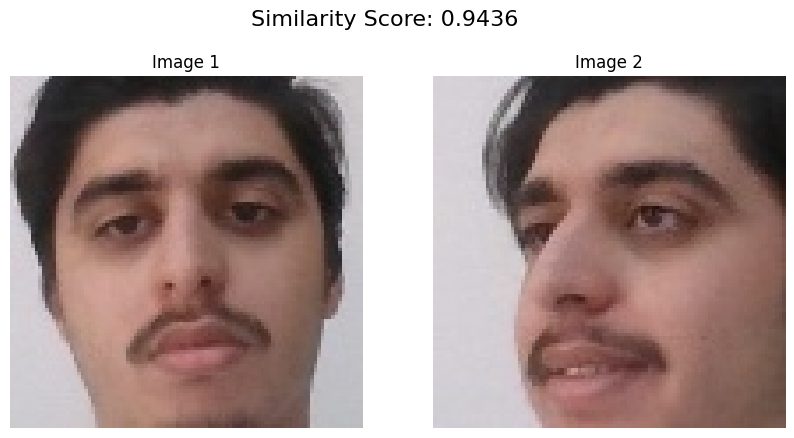

In [9]:
img_path1 = "/kaggle/input/dataset-faces/dataset-final/Omer khan/face_image1.jpg"  # First image path
img_path2 = "/kaggle/input/dataset-faces/dataset-final/Omer khan/face_image7.jpg"  # Second image path

# Predict the similarity between the two images
similarity_score = predict_image_pair(model, img_path1, img_path2, config)
print(f"Similarity score between the two images: {similarity_score:.4f}")

# Determine if the images are from the same person
if is_same_person(similarity_score, threshold=0.9):
    print("Same person")
else:
    print("Different person")

# Display images side by side with the similarity score
display_images_and_similarity_score(img_path1, img_path2, similarity_score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Similarity score between the two images: 0.2295
Different person


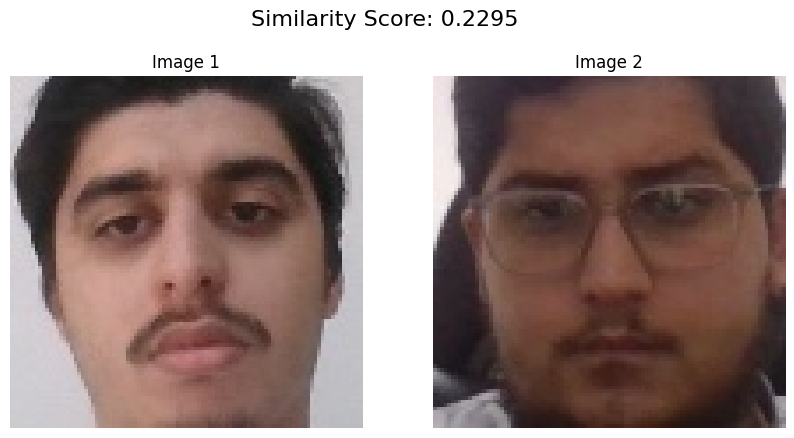

In [ ]:
img_path1 = "/kaggle/input/dataset-faces/dataset-final/Omer khan/face_image1.jpg"  # First image path
img_path2 = "/kaggle/input/dataset-faces/dataset-final/Muhammad Khan/face_image4.jpg"  # Second image path

# Predict the similarity between the two images
similarity_score = predict_image_pair(model, img_path1, img_path2, config)
print(f"Similarity score between the two images: {similarity_score:.4f}")

# Determine if the images are from the same person
if is_same_person(similarity_score, threshold=0.9):
    print("Same person")
else:
    print("Different person")

# Display images side by side with the similarity score
display_images_and_similarity_score(img_path1, img_path2, similarity_score)

<h3>Negative Tests</h3>


Model is unsuitable for facial recognition attendance system because of the limitations discussed in the report.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Similarity score between the two images: 0.3779
Different person


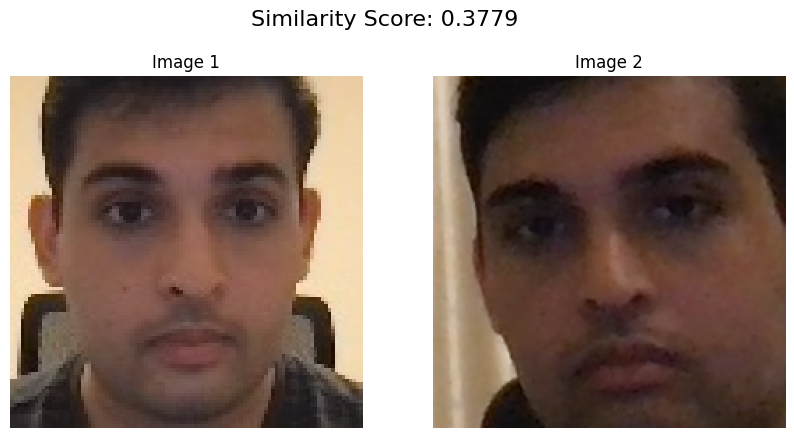

In [ ]:
img_path1 = "/kaggle/input/dataset-faces/dataset-final/Abdullah Nawaz/face_image1.jpg"  # First image path
img_path2 = "/kaggle/input/test-image/Muhammad Khan_detected_1.jpg"  # Second image path

# Predict the similarity between the two images
similarity_score = predict_image_pair(model, img_path1, img_path2, config)
print(f"Similarity score between the two images: {similarity_score:.4f}")

# Determine if the images are from the same person
if is_same_person(similarity_score, threshold=0.9):
    print("Same person")
else:
    print("Different person")

# Display images side by side with the similarity score
display_images_and_similarity_score(img_path1, img_path2, similarity_score)